# Customer Segmentation Report

## Goal:

The purpose of this analysis is to leverage unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. 

We'd like to identify the parts of the general population that are more likely to become part of Arvato future customer base. And, conversely, what parts of general population are less likely to become, and what features determine that.


# 00. Packages & Data
## a. Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
try:
    from tqdm import tqdm
except:
    !pip install tqdm
    from tqdm import tqdm    
%matplotlib inline


### my utils
from sklearn.preprocessing import OrdinalEncoder
from unsupervised_utils import *

## b. Data

In [3]:
%%time 
joint_dataset = pd.read_csv("../arvato_data_processed/joint_dataset_imputed.csv", low_memory = True, index_col = 'Unnamed: 0' )
joint_dataset

CPU times: user 2min 8s, sys: 10.6 s, total: 2min 19s
Wall time: 4min 47s


# 01. Feature Scaling

All our our numerical and ordinal/categorical features are represented as numbers. The vast majority of features represent some notion of ordering (numerical/ordinal), while categorical features usually occur in a binary fashion 0/1.

So, I am going to later apply Principal Components Analysis (PCA) on this dataset. Although PCA is used for continuous variables, we might use PCA in this case as a simplified/naive case. As shown below:

In [7]:
joint_dataset.shape

(932108, 892)

In [ ]:
%%time
plt.hist(joint_dataset.to_numpy().reshape(-1),log=True)
plt.plot()

features are not standardizes. Some represent numerically the year, some represent a single ingerers (0,1,2,3,... etc). In order to treat each feature equally, regardless of the **scale** of the values it can take, I am going to apply a scikit-learn `StandardScaler`.

In [5]:
%%time
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler(feature_range=(-1, 1))
ss = StandardScaler()

column_names = joint_dataset.columns
joint_dataset = mm.fit_transform(joint_dataset)

joint_dataset = pd.DataFrame(joint_dataset,columns=column_names)
joint_dataset

CPU times: user 9.08 s, sys: 5.81 s, total: 14.9 s
Wall time: 14.9 s


CPU times: user 21.3 s, sys: 3.42 s, total: 24.7 s
Wall time: 24.7 s


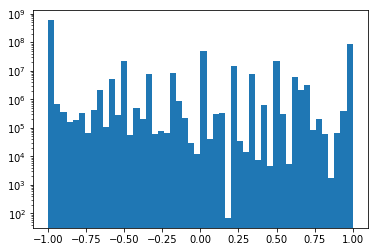

In [6]:
%%time
plt.hist(joint_dataset.to_numpy().reshape(-1),log=True,bins=50)
plt.plot()

In [8]:
np.unique(joint_dataset['D19_VERSI_ONLINE_QUOTE_12_6.0'])

array([-1.,  1.])

we see now that jointly the values taken in our dataset resemble a Gaussian with mean 0 and standard deviation of 1. 

# 02. Correlation analysis and feature grouping:



In [11]:
%%time

corr_threshold=0.90

corr =  joint_dataset.corr()
corr_abs = corr.abs()
joint_dataset,corr_abs,deleted_columns,feature_correlated = remove_correlated(joint_dataset,corr_threshold, corr_matrix=corr_abs)

print("Removed {} columns that were above {} correlation threshold".format(len(deleted_columns),corr_threshold))

Removed 16 columns that were above 0.9 correlation threshold
CPU times: user 17min 24s, sys: 11 s, total: 17min 35s
Wall time: 17min 35s


For future reference we keep the names of the deleted columns in `deleted_columns` variable, and the columns for which they were highly correlated in a dictionary `feature_correlated` shown below:

In [12]:
feature_correlated

{'KBA13_FAB_SONSTIGE': ['KBA13_HERST_SONST'],
 'KBA13_ALTERHALTER_61': ['KBA13_HALTER_66'],
 'D19_GESAMT_ONLINE_QUOTE_12': ['D19_VERSAND_ONLINE_QUOTE_12'],
 'KBA13_KMH_250': ['KBA13_KMH_211'],
 'ANZ_STATISTISCHE_HAUSHALTE': ['ANZ_HAUSHALTE_AKTIV'],
 'CAMEO_DEUINTL_2015': ['CAMEO_DEUG_2015', 'CAMEO_DEUINTL_2015_SIM'],
 'D19_TELKO_ONLINE_QUOTE_12_0.0': ['D19_VERSI_ONLINE_QUOTE_12_0.0',
  'D19_KONSUMTYP_MAX_9'],
 'CJT_TYP_3_5.0': ['CJT_TYP_4_5.0'],
 'FIRMENDICHTE_5.0': ['GEBAEUDETYP_RASTER_5.0'],
 'LP_LEBENSPHASE_GROB_0.0': ['LP_LEBENSPHASE_FEIN_0.0'],
 'LP_FAMILIE_GROB_1.0': ['LP_FAMILIE_FEIN_1.0'],
 'LP_FAMILIE_GROB_2.0': ['LP_FAMILIE_FEIN_2.0'],
 'KBA05_MODTEMP_5.0': ['KBA05_HERSTTEMP_5.0'],
 'D19_KONSUMTYP_MAX_8': ['D19_KONSUMTYP_9.0']}

**For example** we see that `PLZ8_ANTG1` and `KBA13_ANTG1` are highly correlated features, from which `KBA13_ANTG1` was removed.

When looking back to **metadata descripton** `DIAS Attributes - Values 2017` we see that  `PLZ8_ANTG1` refers to "number of 1-2 family houses in the PLZ8", while for feature `KBA13_ANTG1` we lack any metadata description, and due to the common suffix they might refer to very similar feature.

Thus, we remove some 16 highly correlated features in this step of the analysis

Initial correlation matrix indicates that not many features are correlated with each other. I used `abs` to compute an absolute correlation coefficient. At this point we only care about the relative correlation, and not its directionality. 

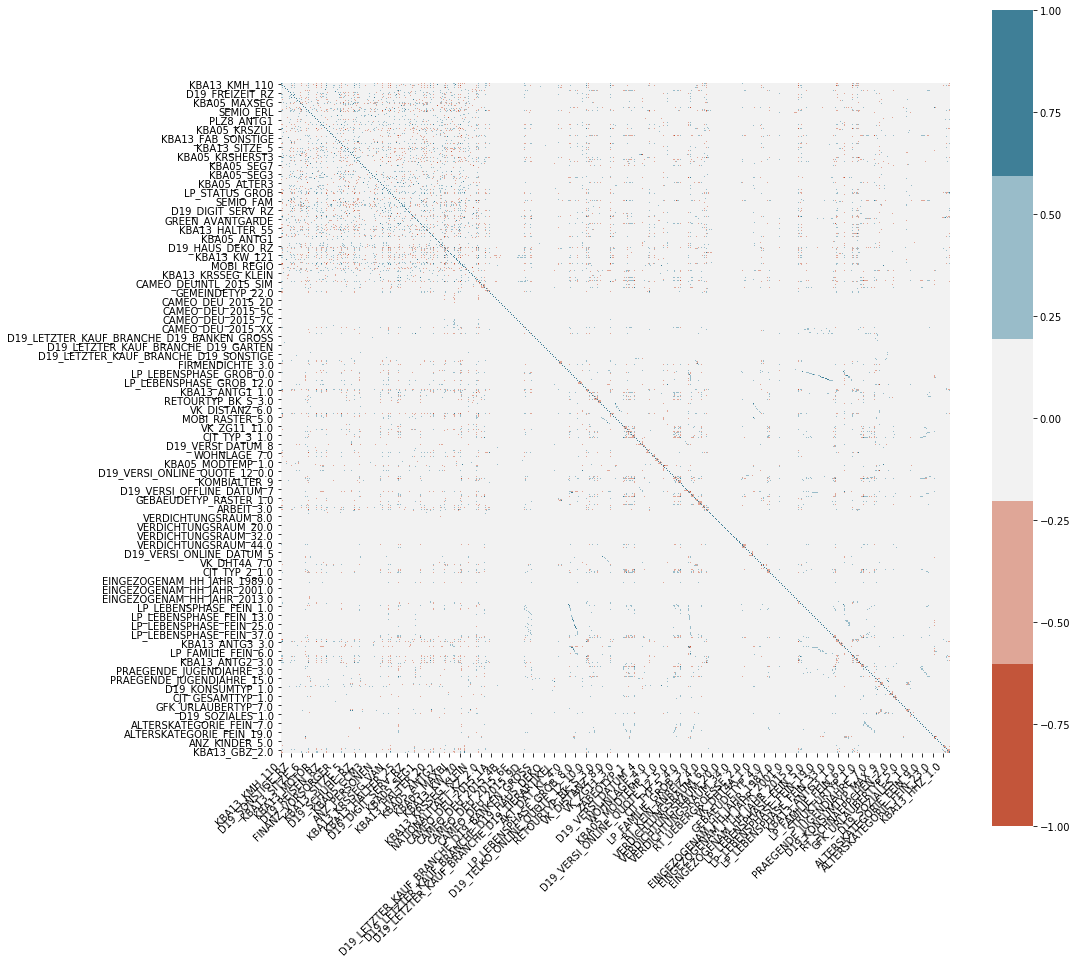

In [13]:
plt.figure(figsize=(15,15))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 225, n=5),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

# 02. Dimensionality reduction & Variance explained

As we want to cluster our data with many features, it would be beneficial to identifiy the redundancies in our dataset and redue the number of features to address the **curse of dimensionality** problem for clustering high dimensional data.

First. I will look over the variance explained by each features cumulatively, and compress the data so that it retains a significant portion of the variance explained. 

This 80% used below is an arbitrary threshold, a tradeoff between representing data accurately, and reducing the number of features. The compression is done by PCA: we identify ortogonal PC axes, that are a linear combination of features. As each PC is ordered by the importance (i.e. the amount of variance it explains), and we'll "trim" the last PC axes that contribute little to understand the dataset.



In [15]:
%%time
from sklearn.decomposition import PCA

pca = PCA(n_components= joint_dataset.shape[1])
joint_dataset_PCA = pca.fit_transform(joint_dataset)

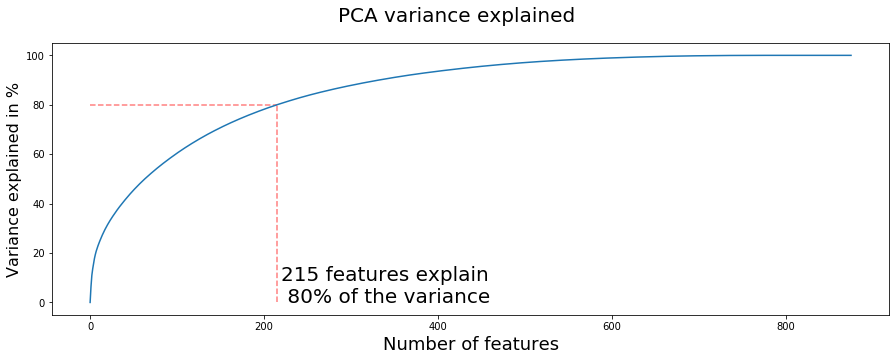

In [16]:
variance_explained(pca,80)

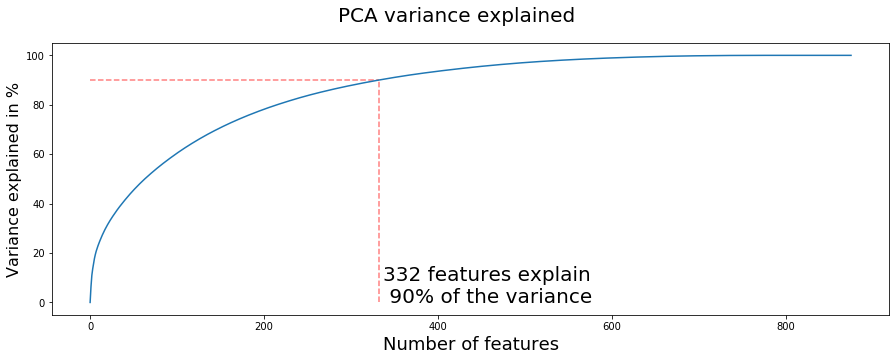

In [17]:
variance_explained(pca,90)

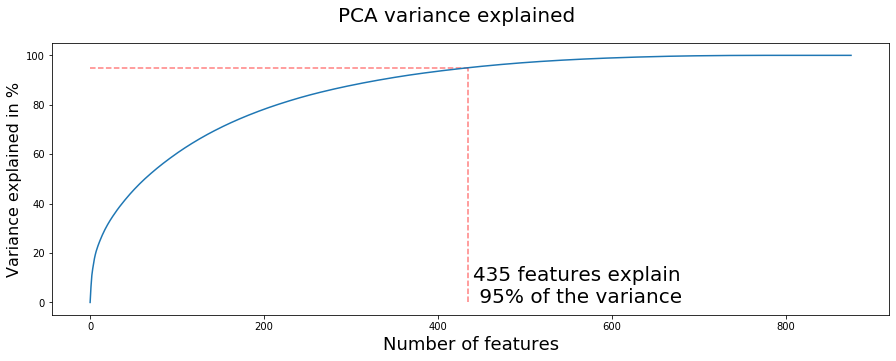

In [18]:
variance_explained(pca,95)

In [19]:
joint_dataset_PCA = pd.DataFrame(joint_dataset_PCA,columns=joint_dataset.columns)
joint_dataset_PCA

,KBA13_KMH_110,RELAT_AB,KBA13_BJ_1999,PLZ8_ANTG3,KBA13_SEG_MINIWAGEN,D19_ENERGIE_RZ,KONSUMZELLE,D19_BANKEN_LOKAL_RZ,KBA05_SEG2,KBA05_ZUL4,...,KBA13_HHZ_1.0,KBA13_HHZ_2.0,KBA13_HHZ_3.0,KBA13_HHZ_4.0,KBA13_HHZ_5.0,KBA13_GBZ_1.0,KBA13_GBZ_2.0,KBA13_GBZ_3.0,KBA13_GBZ_4.0,KBA13_GBZ_5.0
0,-6.881385,2.768480,2.384437,-2.970263,-1.794474,1.646037,0.511248,-0.165435,-2.019601,-0.935936,...,1.247438e-14,3.001703e-15,-6.406983e-15,-7.992252e-15,9.751061e-15,4.134965e-15,2.799544e-15,-8.167509e-15,-5.853894e-15,1.184615e-15
1,-1.274147,6.852459,1.011670,-1.577932,-0.811514,-1.474080,2.349136,0.000167,-0.934805,3.451201,...,1.990805e-14,1.589967e-14,8.048368e-15,1.035657e-14,-9.938238e-15,-5.083238e-16,-7.963728e-15,4.228591e-15,-1.954413e-15,-2.188094e-16
2,-5.820283,1.659852,-2.576726,-1.217234,-2.759879,2.017917,0.801818,0.606609,0.813914,-2.315082,...,-3.285522e-15,-1.266563e-14,8.958048e-15,9.908043e-15,6.911876e-15,5.576119e-16,-3.135044e-15,-7.406296e-15,-3.528615e-15,2.569879e-15
3,2.070933,-0.488896,2.150218,4.488290,2.645374,1.847878,-0.990482,-4.351751,0.502767,2.901674,...,1.524138e-14,-5.544023e-15,1.930964e-14,1.423262e-15,1.510272e-15,-1.370723e-14,-8.236276e-15,1.210882e-15,4.921230e-15,-2.276402e-15
4,-4.537549,3.336891,6.387604,-1.766316,-0.681421,1.732701,-1.176126,-0.740861,1.463444,0.652291,...,6.997597e-16,1.905929e-14,-3.230390e-15,5.913247e-16,-7.236237e-15,-6.556913e-15,1.146378e-15,-3.535651e-15,4.702005e-16,-9.220660e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932103,0.477982,-5.166395,-0.340699,-0.852682,-0.739866,-2.519197,-0.205778,1.260891,0.530806,2.120618,...,-1.255701e-16,8.709563e-17,-6.329844e-17,2.876790e-17,-4.728286e-17,-2.935052e-17,-6.419291e-17,-2.589111e-17,-6.084313e-18,-1.673467e-17
932104,7.248155,0.915463,-0.635910,-0.103951,0.569204,1.346384,3.546160,-0.701866,0.372757,0.888691,...,2.652973e-17,2.100722e-17,6.343775e-17,-2.316759e-17,-6.193314e-17,3.397424e-17,2.928287e-17,-4.744225e-17,3.153772e-18,-9.363907e-18
932105,-0.893755,-5.905390,-0.561261,-1.600045,-1.505935,-1.951962,1.598843,-1.001025,1.075920,0.604594,...,6.068688e-17,-4.107804e-17,-4.552949e-17,-5.945161e-17,8.448244e-17,1.281870e-17,4.393730e-17,2.236177e-17,-2.640080e-17,1.445273e-17
932106,7.071785,-1.969070,-0.611305,1.400633,-4.354454,2.191783,-1.304681,-1.685727,-2.670279,0.286071,...,1.413076e-16,-6.279583e-18,-1.697170e-17,6.729779e-17,-5.640298e-18,-4.201127e-17,9.346893e-17,4.621635e-17,-3.334018e-17,6.584637e-18


In [20]:
components_to_keep=215


joint_dataset_PCA_reduced = joint_dataset_PCA.iloc[:,:components_to_keep]
joint_dataset_PCA_reduced.shape

(932108, 215)

# 03. Clustering

## A. Estimating the best number of clusters

Finding optimal number of clusters with kmeans and the "elbow method". Leter I'll show cluster distributions of azdias vs customers and try to understand cluster centroids vs PC axes.

In [21]:
%%time
sum_of_squared_distances,calinski_harabasz_scores = elbow_kmeans(X=joint_dataset_PCA_reduced, clusters=25)

import pickle

with open('sum_of_squared_distances.pkl', 'wb') as pickle_file:
    pickle.dump(sum_of_squared_distances, pickle_file)

with open('calinski_harabasz_scores.pkl', 'wb') as pickle_file:
    pickle.dump(calinski_harabasz_scores, pickle_file)



2/25
	 ...Fitted
	 Computed calinski harabasz score
	 Computed sum of squares distance score
3/25
	 ...Fitted
	 Computed calinski harabasz score
	 Computed sum of squares distance score
4/25
	 ...Fitted
	 Computed calinski harabasz score
	 Computed sum of squares distance score
5/25
	 ...Fitted
	 Computed calinski harabasz score
	 Computed sum of squares distance score
6/25
	 ...Fitted
	 Computed calinski harabasz score
	 Computed sum of squares distance score
7/25
	 ...Fitted
	 Computed calinski harabasz score
	 Computed sum of squares distance score
8/25
	 ...Fitted
	 Computed calinski harabasz score
	 Computed sum of squares distance score
9/25
	 ...Fitted
	 Computed calinski harabasz score
	 Computed sum of squares distance score
10/25
	 ...Fitted
	 Computed calinski harabasz score
	 Computed sum of squares distance score
11/25
	 ...Fitted
	 Computed calinski harabasz score
	 Computed sum of squares distance score
12/25
	 ...Fitted
	 Computed calinski harabasz score
	 Computed sum 

In [22]:
import pickle

with open('calinski_harabasz_scores.pkl', 'rb') as pickle_file:
    calinski_harabasz_scores = pickle.load(pickle_file)

with open('sum_of_squared_distances.pkl', 'rb') as pickle_file:
    sum_of_squared_distances = pickle.load(pickle_file)

It took around 3.5h hours to perform k-means clustering on our dataset with k varying from 2 to 25. Here are the scores:

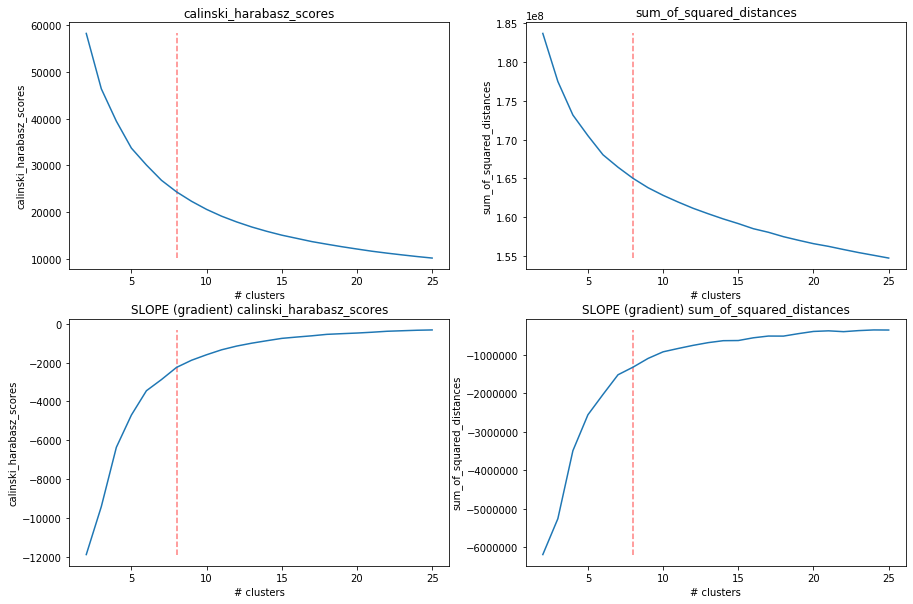

In [25]:
fig,axs = plt.subplots(2,2,figsize=(15,10))

cluster_no = np.arange(2,25+1)

chosen_cluster=8

axs[0,0].plot(cluster_no, calinski_harabasz_scores)
axs[0,0].set_title("calinski_harabasz_scores")
axs[0,0].set_xlabel("# clusters")
axs[0,0].set_ylabel("calinski_harabasz_scores")
axs[0,0].vlines(chosen_cluster,ymax=max(calinski_harabasz_scores),ymin=min(calinski_harabasz_scores),color='red',linestyle='dashed',alpha=0.5)

axs[0,1].plot(cluster_no,sum_of_squared_distances)
axs[0,1].set_title("sum_of_squared_distances")
axs[0,1].set_xlabel("# clusters")
axs[0,1].set_ylabel("sum_of_squared_distances")
axs[0,1].vlines(chosen_cluster,ymax=max(sum_of_squared_distances),ymin=min(sum_of_squared_distances),color='red',linestyle='dashed',alpha=0.5)

axs[1,0].plot(cluster_no,np.gradient(calinski_harabasz_scores))
axs[1,0].set_title("SLOPE (gradient) calinski_harabasz_scores")
axs[1,0].set_xlabel("# clusters")
axs[1,0].set_ylabel("calinski_harabasz_scores")
axs[1,0].vlines(chosen_cluster,ymax=max(np.gradient(calinski_harabasz_scores)),ymin=min(np.gradient(calinski_harabasz_scores)),color='red',linestyle='dashed',alpha=0.5)


axs[1,1].plot(cluster_no,np.gradient(sum_of_squared_distances))
axs[1,1].set_title("SLOPE (gradient) sum_of_squared_distances")
axs[1,1].set_xlabel("# clusters")
axs[1,1].set_ylabel("sum_of_squared_distances")
axs[1,1].vlines(chosen_cluster,ymax=max(np.gradient(sum_of_squared_distances)),ymin=min(np.gradient(sum_of_squared_distances)),color='red',linestyle='dashed',alpha=0.5)


### Choosing the number of clusters (discussion)

Choosing the number of clusters is an arbitrary task. First, let's discuss metrics used:

1. `Calinski-Harabasz score`:  also known as the Variance Ratio Criterion. The score is defined as ratio between the within-cluster dispersion and the between-cluster dispersion. Hence we want to obtain a minimum possible with the least amount of clusters available (the most conservative approach). If the number of clusters is equal to the number of points, then this score will be 0, but the solution would be far from optimal.

2. ` Inertia or the sum of square distances of samples` to their closest cluster center. The smaller the inertia, the better, but a naive minimization (as with calinski-harabasz score) is ill advised, as with number of clusters equal to the number of points we have a guarantee to obtain a minimum.


Hence, despite having two metrics, the choice of cluster number is arbitrary. And in a thorough experiments each would have to be tested. 


# I am going to assume that the number of clusters is 8
I decided on that number based on the shape of the elbow from both score. I also print the gradient (i.e. derivative) of the scores, to show when the gradients ae becoming "flat" indicating a decrease in the "speed" of metric score decrease.

The optimal solution lies in the range 6-15. With **8 clusters** seeming to offer a nice score minimization, with conservative approach of not inflating the number of clusters.

The last step in deciding on the number of clusters, is to check the cluster assignement stability. 

I implemented a function `cluster_stability` in `unsupervised.utils.py` based on [this github post on scikit-learn page](https://github.com/scikit-learn/scikit-learn/issues/1091). Bascially I **randomly sample my dataset**, each time with different initialization seed corresponding to different centroid initialization locaitons. I  keep  only `percent` of the original data to save the time, and repeat this procedure `n_iter` times. For each iteration I compute the `adjusted_rand_score`.

"from scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html):
> "The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings. The adjusted Rand index is thus ensured to have a value close to 0.0 for random labeling independently of the number of clusters and samples and exactly 1.0 when the clusterings are identical (up to a permutation)."

Thus, a score as close to 1.0 is good, whereas 0.0 is the worst score, i.e. random labeling independently of the number of clusters.

In [26]:
%%time

n_clusters=8

from sklearn.cluster import KMeans
from sklearn import metrics
estimator = KMeans(n_clusters=n_clusters)

cluster_stability_score = cluster_stability(joint_dataset_PCA_reduced.to_numpy(),estimator,percent=.25 ,n_iter=10)
cluster_stability_score

Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10
CPU times: user 16min 47s, sys: 16.3 s, total: 17min 3s
Wall time: 11min 26s


0.9763646672454361

We see that if we run 10 iterations, each time randomly bootstrap a dataset containing 25% of our dataset, and compute the clustering with **8 clusters**, we obtain a very high adjusted RAND Index, meaning **that 8 clusters assignement** is a very stable measure.

The rand index score is around **0.98**.

---
## B. Cluster relative abundances between Arvato `customers` and German general population: `azdias`.

We know from the notebook `03_Concatenate_and_Impute.ipynb` that:

> "The joint dataset has 932108 rows. The first 140864 rows are coming from customers dataset, the latter 791244 come from general population, i.e. AZDIAS dataset"

hence, we can recover dataset labels for the rows (observations). This is handy, as we can compare general population to ARVATO customer base

In [27]:
%%time # 4 minutes
estimator.fit(joint_dataset_PCA_reduced)
joint_dataset_PCA_reduced_labels = estimator.predict(joint_dataset_PCA_reduced)

CPU times: user 5min 27s, sys: 11.4 s, total: 5min 38s
Wall time: 4min


In [99]:
# SAVE kmeans model (with centroid) and predicted labels to ensure reproducibility

np.save('joint_dataset_PCA_reduced_labels',joint_dataset_PCA_reduced_labels)

import pickle
with open("PCA_kmeans_estimator",'wb') as file:
    pickle.dump(estimator, file)

In [28]:
# num. of samples per dataset
azdias_samples = 791244 
customers_samples = 140864 

# create a Pandas Dataframe that would contain the relative percentage of class abundance PER DATASET
#    this would allow to compare class abundances between general population and arvato customers

DataSet_labels = ["customers"]*140864 + ["azdias"]*azdias_samples # dataset labels
assert len(DataSet_labels) == joint_dataset_PCA_reduced_labels.shape[0] #snity check
culuster_assignements = pd.DataFrame( {'Cluster': joint_dataset_PCA_reduced_labels,  'DataSet':DataSet_labels  }  )
culuster_assignements['count']=1
culuster_assignements = culuster_assignements.groupby(["DataSet","Cluster"]).count()

a = culuster_assignements.loc[('azdias')]*100/azdias_samples
a['dataset']='azdias'
a['cluster']=a.index


b = culuster_assignements.loc[('customers')]*100/customers_samples
b['dataset']='customers'
b['cluster']=b.index

culuster_assignements = pd.concat([a,b])
del a,b
culuster_assignements


,count,dataset,cluster
Cluster,,,
0,9.973914,azdias,0
1,15.220084,azdias,1
2,6.316004,azdias,2
3,13.038709,azdias,3
4,15.643594,azdias,4
5,12.052919,azdias,5
6,12.819307,azdias,6
7,14.935469,azdias,7
0,17.271269,customers,0


<Figure size 1800x216 with 0 Axes>

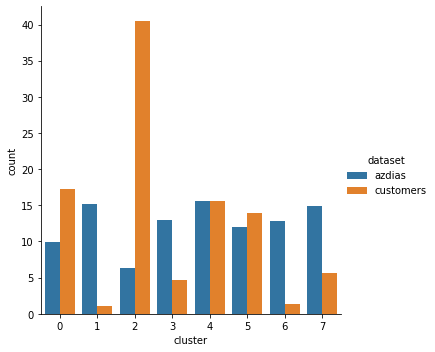

In [37]:
plt.figure(figsize=(25,3))
sns.catplot(x='cluster', y='count', hue='dataset', data=culuster_assignements, kind='bar')
 


## discussion: clusters relative abundance differences between `customers` and general populations `AZDIAS`

Before I go on to explore the characteristics of each cluster, I want to discuss the relative proportions on the above plot. We see that we have **8 clusters** on the `x`-axis. I plot the relative proportions for Arvato customers (`customers`) and the general population (`azdias`).  Each add separately (per dataset)  to 100% relative abundance. 

We can observe the following:


**Clusters 1, 3, 6, 7:**:
    - these are the segments of general population for which Arvato has relatively less customers. Meaning this segment of population is **less likely to use the services**, as customers from this segment are less prevalent in our customer dataset.
    
**Clusters 0, 2 :**
    - these are the segments of general population that are overrepresented in Arvato customer base. Meaning, **this segment of population is much more likely (constitutes higher percentage) to use Arvato services**.
    
**Cluster 4,5:**
    - this is the segment of population that is  equally represented in customers dataset with relatively high percentage. Meaning this is also an important from the business perspective segment of the market.

Also, we want to plot the relative abundances of our customer base, to see what are **the most important market segments** (the ones with the greates relative abundances)

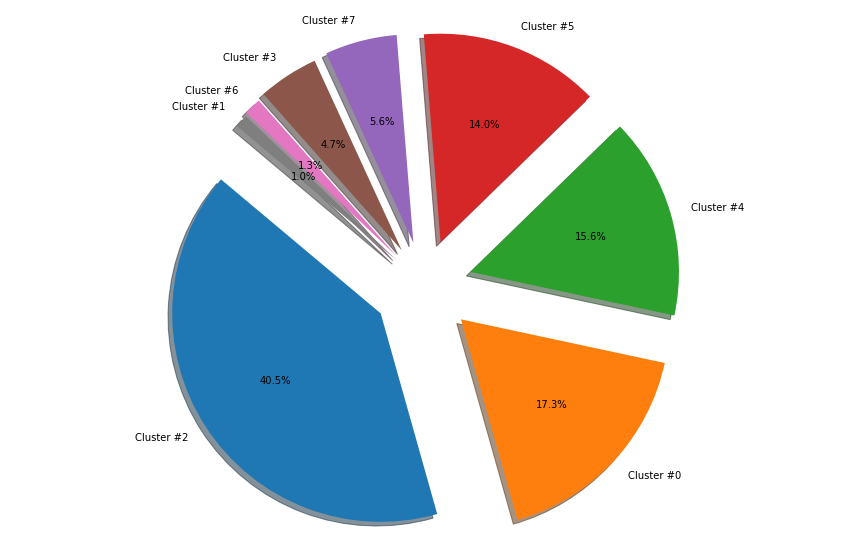

In [70]:
cust_counts = culuster_assignements[culuster_assignements['dataset']=="customers"]
cust_counts = cust_counts.sort_values('count',ascending=False)
labels = ["Cluster #{}".format(x) for x  in  list(cust_counts['cluster'])]

explode = [ max(0, 0.25-i*0.01  ) for i in range(8)]



plt.figure(figsize=(15,10))
plt.pie(cust_counts['count'], explode=explode, labels=labels, 
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

---
# C. correlate PC with clusters

So, we ended up with **8 clusters** that are characterized by **8 centroids** each embedded in `components_to_keep`-dimensional space, as described by `joint_dataset_PCA_reduced`.

Hence we can construct a matrix of cluster centroids and their corresponding PC values:

In [78]:
centroids = pd.DataFrame(estimator.cluster_centers_, columns = ["PC_"+str(i) for i in range(1,components_to_keep+1)])
centroids.index = ["Cluster_"+str(i) for i in range(0,n_clusters)]
centroids

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_206,PC_207,PC_208,PC_209,PC_210,PC_211,PC_212,PC_213,PC_214,PC_215
Cluster_0,-4.656767,1.667749,-2.490989,-1.042185,-1.059461,-0.230689,0.940555,-0.199507,-0.214283,-0.114169,...,-0.002449,0.016881,-0.002330,0.010490,0.004527,0.002576,0.013507,-0.000485,-0.009257,-0.011177
Cluster_1,2.664578,-3.122890,-0.018133,-2.478479,-0.727795,-0.392454,-1.070144,-0.351123,0.318075,0.013499,...,-0.003243,0.015187,-0.000455,-0.024687,-0.014809,-0.011167,-0.001390,0.018135,0.011825,-0.009659
Cluster_2,-4.356568,2.641830,2.771152,-0.298587,-1.213495,0.309122,-0.681105,0.335223,-0.357895,0.308914,...,-0.005221,0.002962,-0.015868,0.030289,-0.005902,0.031476,0.026193,0.048594,0.001802,0.001989
Cluster_3,-1.482800,-4.985599,0.448185,0.271255,-0.992977,-0.094787,0.099204,0.185085,0.185644,-0.062817,...,-0.019065,-0.031109,-0.009493,0.001659,0.026228,0.021313,-0.021687,-0.022695,-0.022415,-0.009224
Cluster_4,-3.089362,-1.729326,-0.376448,1.282457,2.412361,0.223920,0.148006,0.152877,-0.080549,-0.077528,...,0.013664,0.014089,0.026469,-0.021779,-0.002635,-0.028342,-0.008190,-0.007952,0.019206,0.003057
Cluster_5,1.212917,5.522574,-0.906717,0.131045,-0.896703,-0.636384,-0.043167,-0.428482,0.462891,-0.231997,...,0.002150,0.013055,0.021892,-0.006704,0.013361,-0.012677,-0.023407,-0.040142,-0.008361,0.005839
Cluster_6,6.677295,-1.025967,0.516270,0.396690,-1.860888,0.033549,1.069718,0.519734,-0.583922,0.121538,...,-0.007130,-0.009358,-0.004679,0.011221,0.002165,0.003829,0.012333,-0.007010,-0.005191,0.023109
Cluster_7,3.217951,1.549023,0.155573,1.339148,3.019882,0.683032,-0.252739,-0.154466,0.159512,0.074758,...,0.014245,-0.024494,-0.022688,0.010235,-0.018132,0.004636,0.007653,0.012961,0.003802,-0.002982


I can plot a heatmap:

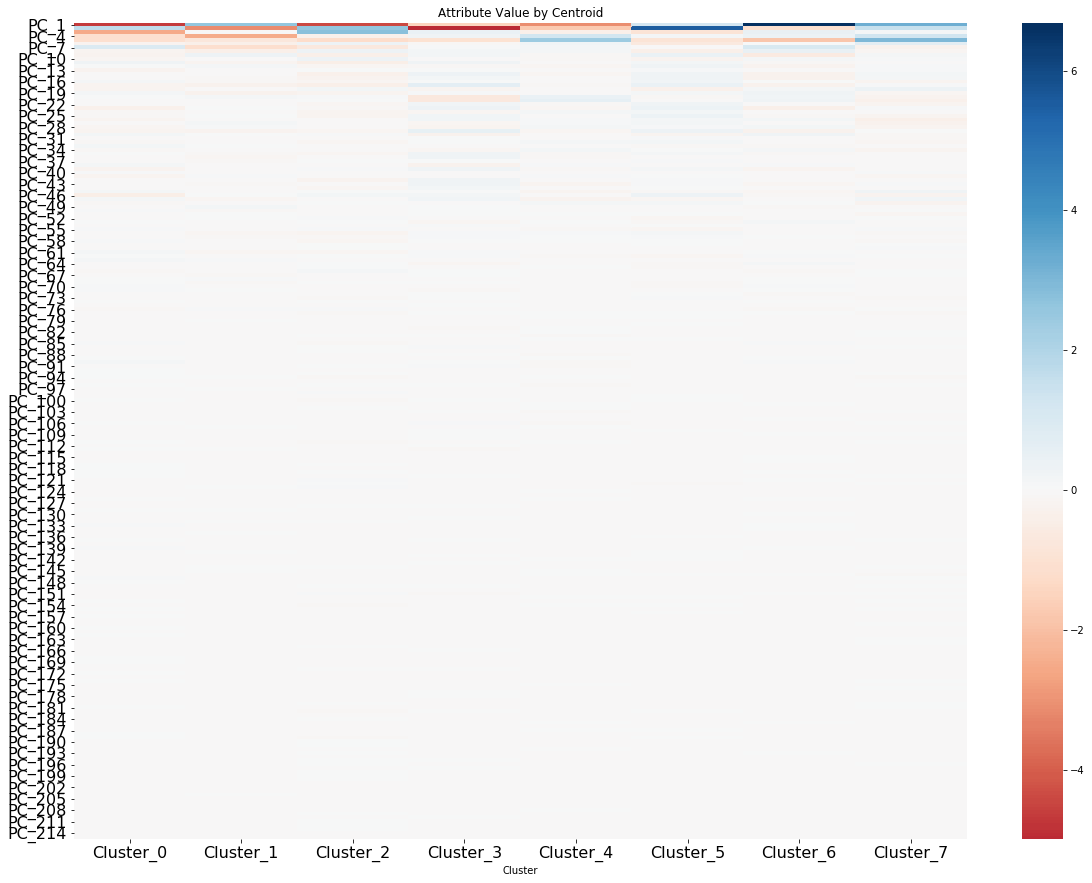

In [79]:
plt.figure(figsize = (20,15))
ax = sns.heatmap(centroids.T, cmap = 'RdBu',center=0)
ax.set_xlabel("Cluster")
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
ax.set_title("Attribute Value by Centroid")


plt.show()

(Figure Above) First, we see that although the reduced dataset (with 80% variance kept) is described by `components_to_keep` PC axes, only the top 10 exibit values largely above/below zero. This will help us greatly in simplifying the interpretations.

(Figure below) We can zoom in on the **first TOP 5 PC axes**:

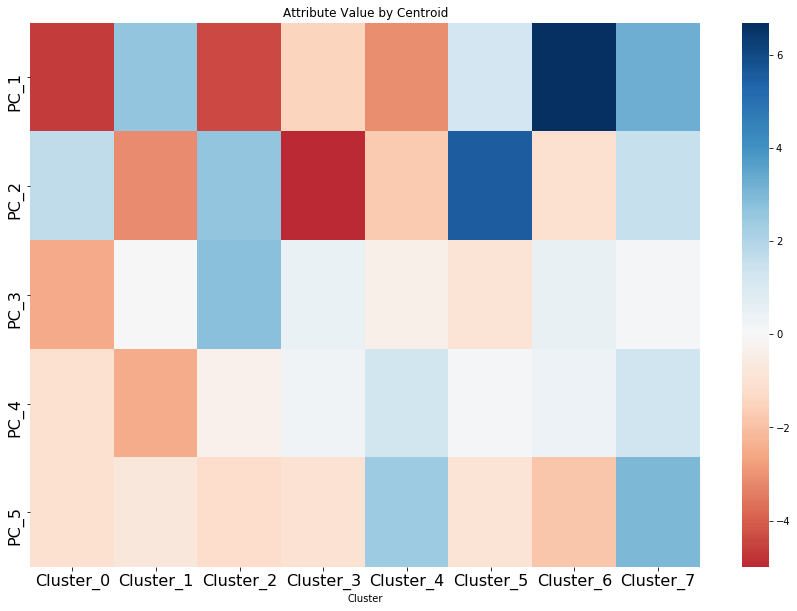

In [82]:
top_PCs=5

plt.figure(figsize = (15,10))
ax = sns.heatmap(centroids.iloc[:,:top_PCs].T, cmap = 'RdBu',center=0)
ax.set_xlabel("Cluster")
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
ax.set_title("Attribute Value by Centroid")
plt.show()

Looking at the heatmap above we can note **generalizations for each cluster**, such that:

**Note**, PCs are numbered from 1-169. Clusters are numbered from 0-5.

1. `Cluster_0`:
    - is described hugely by **strongly negative** values of **PC1**, and to a some degree **PC3**, while being anticorrelated with **positive PC2 values** that has mediocre impact on this cluster.
    
2. `Cluster_1`
    - is described primarily  by **positive PC1 values** and **negative PC2/PC4**

3. `Cluster_2`
    - is described primarily  by **positive P2/P3 values** and **negative PC1 values**

4. `Cluster_3`
    - is described primarily  by **negative PC2 and PC1** with stongly negative PC2 values

5. `Cluster_4`
    - is described primarily  by **negative PC2 and PC1**, but comparing to cluster 3, less strong values for PC2, slightly more importance in PC1

6. `Cluster_5`
    - is described primarily  by  **positive PC2 and PC1** values, with strong PC2 values
    
7. `Cluster_6`
    - is described primarily  by  **positive PC2 and PC1** values, with strong PC1 values
    
8. `Cluster_7`
    - is described primarily  by  positive values in all considered PCs (1-5), without any strong values

Now that I described how each cluster is relating to PC components, that are a linear combination of our original features. It is time to untangle the first 5 PC axes (for simplicity, but nothing prevents us from going to less impactful PCs 5-`components_to_keep`).

---
## D. PC decomposition: feature importance

In order to better understand the makup of the clusters, we identified the PCs, and its values that largely define these clusters. 

But we can use the nature of the PCA as a linear combinaiton of our original feature space to disentangle the "meaning" of each PC, by looking at top `n` contributors of variance to that PC.

I present the plots, and provide comments for first **5 PCs**, each characterized by **top 10 featues** (variables defined in the raw dataset) regarding the potential interpretation of this axis.


**NOTE**: One thing needs claryfing. The PCA components described below show the direction of maximum variance in the data. In detail if a particular feature has

- **POSITIVE** high component values, it means that as PC values increase, the values of a particular feature increase as well (positive correlation)

- **NEGATIVE** high component values, it means that as PC values increase, the values of a particular feature **decrease** (negative correlation).

This will be more evident in exampels shown below.

I also provide a descriptive summary for each PCA and what it means to have a positive and negative values:

# Principal Component Axis #1 (PCA1)
## GENERAL WEALTH

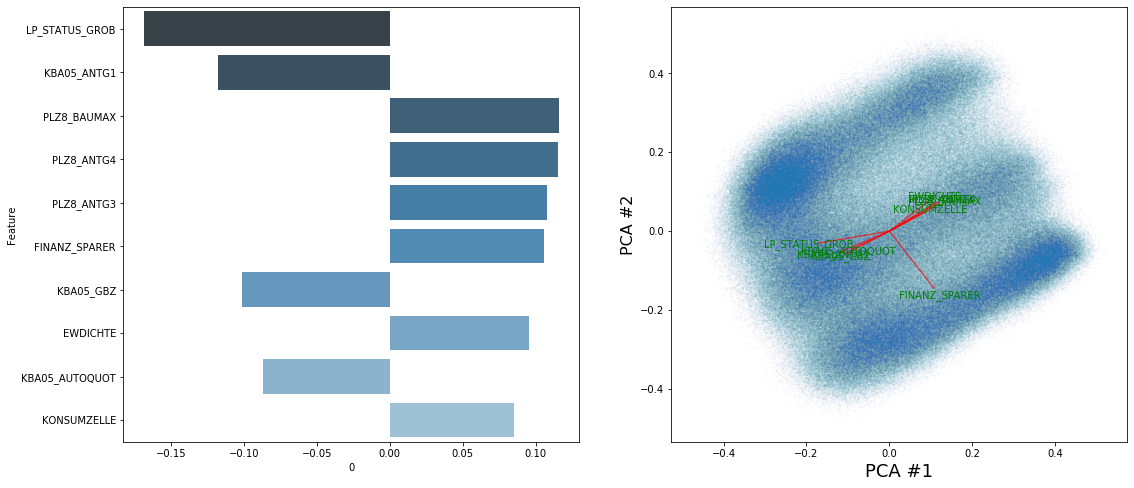

In [83]:
feature_importance_df = pca_explainer(pca = joint_dataset_PCA_reduced, 
                    pca_comonents = pca.components_, 
                    pca_num=1, 
                    n_weights=10,
                                      # Plotting/Figure parameters
                    alpha=0.025,
                    size=.5,
                    plot_arrows=True,
                    width=18,height=8)

### PCA 1 description:

**positive feature correlation** with PCA #1:

1. `PLZ8_BAUMAX`
2. `PLZ8_ANTG4`
3. `PLZ8_ANTG3`
4. `FINANZ_SPARER`
5. `EWDICHTE`
6. `KONSUMZELLE`


**negative feature correlation** with PCA #1:
1. `LP_STATUS_GROB`
2. `KBA05_ANTG1`
3. `KBA05_GBZ`
4 `KBA05_AUTOQUOT`

Now we need to go back to the **metadata file to** read the desciption of each PC. First we note that the top positive features refer to [PLZ8](https://www.ddsgeo.com/products/plz8.html) feature which is a postal code region.

**Positive values of features** mean that PCA#1: refers to regions with mostly business buildings, or regions with many family homes (cities?), high share of  6-10 and >10 family homes, strong many spenders (very low on money savings side), areas of high density of inhabitants, and high values of `KONSUMZELLE` (for which we do not have metadata description) but that might describe high values of consumer spending. 

**Negative values of features** for PCA#1 mean that they segment is **negative** for low-income earners, i.e. comprisong of high-income earners. Interpreting futher it is associated with very high share of family homes, high number of houses in the microcell, and very high number of cars per house hold.
    
     
In other words, interpreting the above:
- **POSITIVE HIGH VALUES of this PC axes** correspond to wealthy individuals that are not savers, have multiple cars, live in wealthy neighbourhoods or cities of high population

- **NEGATIVE HIGH VALUES of this PC axes** correspond to poor individuals, that are strong savers, don't have a lot of cars, might live in less densly populated areas, like countryside.
    
    

# PCA #2

## MONEY MANAGEMENT

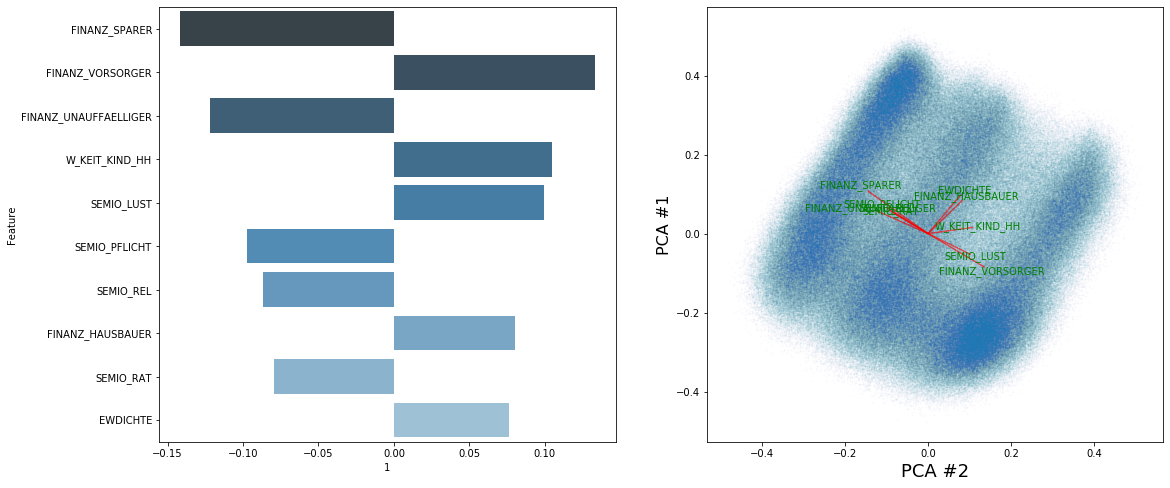

In [84]:
feature_importance_df = pca_explainer(pca = joint_dataset_PCA_reduced, 
                    pca_comonents = pca.components_, 
                    pca_num=2, 
                    n_weights=10,
                                      # Plotting/Figure parameters
                    alpha=0.025,
                    size=.5,
                    plot_arrows=True,
                    width=18,height=8)

### PCA 2 description:

**positive feature correlation** with PCA #2:

1. `FINANZ_VORSORGER`
2. `W_KEIT_KIND_HH`
3. `SEMIO_LUST`
4. `FINANZ_HAUSBAUER`
5. `EWDICHTE`


**negative feature correlation** with PCA #2:
1. `FINANZ_SPARER`
2. `FINANZ_UNAUFFAELLIGER`
3. `SEMIO_PFLICHT``
4. `SEMIO_REL`
5. `SEMIO_RAT`

---

Now we need to go back to the **metadata file to** read the desciption of each PC. 

**Positive values of features** mean that PCA#2: customers do not count of "financial preparedness" (and probably not because they are reckless, but because they can afford not to think about it), the child is very unlikely to be present in that household, people in this household are not very sensual/emotion minded, whose main focus is not really to own a house. People associated with this household live in an area of high population density.

**Negative values of features** for PCA#2 mean that there is negative correlation with the highest values of that feature. Interpreting this means that it is associated with "negative of very low saving" so high degrees of saving, "remarkable" financial typology (whatever that means from metadata). People in these household are traditionally minded (in German terms this might explain the high saving part), very religious households with very rational attitude
     
In other words, interpreting the above:
- **HIGH VALUES of this PC axes** mean households in high population density locations, most likely without children, with people ordiented on money saving, with "remarkable" money management schemes, that are rational, and most likely traditionally religious

- **LOW VALUES of this PC axes**  means the oppositive of high PC values: so people that most likely live outside of high density locations, with children, not particularly focused on money savings, but concerned about "financial preparedness" (so wise spending), probably more swayed by emotions and less traditionally religious.
    

# PCA #3
## LUXURY (cars,ideas) (vanity?)

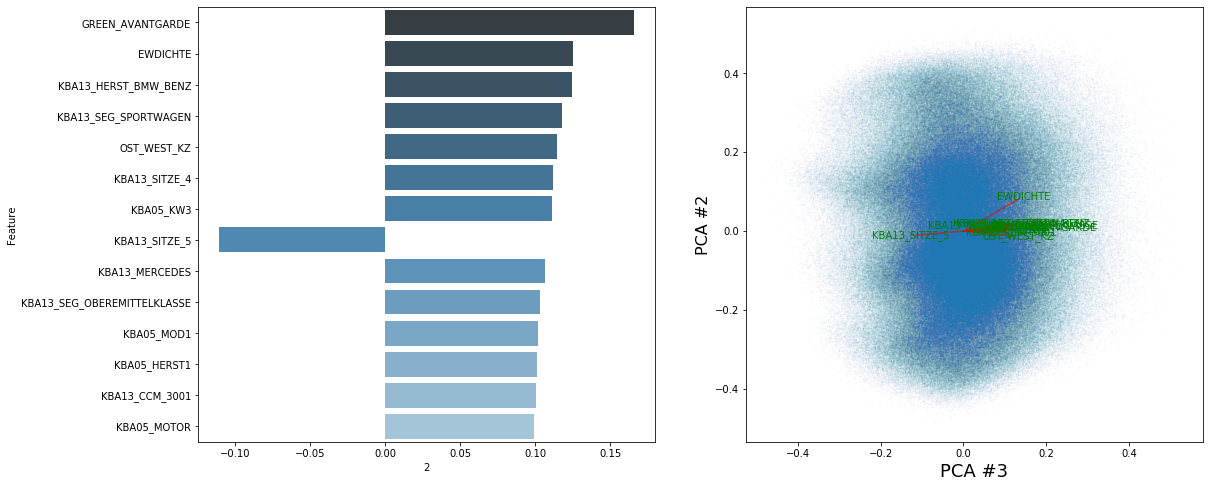

In [88]:
feature_importance_df = pca_explainer(pca = joint_dataset_PCA_reduced, 
                    pca_comonents = pca.components_, 
                    pca_num=3, 
                    n_weights=14,
                    size=.5,
                    plot_arrows=True,
                    width=18,height=8)

---
### PC #3 Description


**positive feature correlation** with PCA #3:
 1. `GREEN_AVANTGARDE`
 2. `EWDICHTE`
 3. `KBA13_HERST_BMW_BENZ`
 
 4. `KBA13_SEG_SPORTWAGEN`
 5. `OST_WEST_KZ`
 6. `KBA13_SITZE_4`
 
 7. `KBA05_KW3`
 8. `KBA13_MERCEDES`
 9. `KBA13_SEG_OBEREMITTELKLASSE`


**negative feature correlation** with PCA #3:
 1. `KBA13_SITZE_5`
 

Now we need to go back to the **metadata file to** read the desciption of each PC. 

**Positive values of features** MEAN for PCA#3: customers belong to "green avantgarde", live in high density of inhabitants per square kilometer, wigh high share of cars like: BWM BENZ, "general sports cars" and Mercedes. These cars are most likely with less than 5 number of seats (i.e. sports cars, feature `KBA13_SITZE_4`) and are very likely to have power more than 119 KW . Hence the share of upper middle class cars and upper class cars (BMW5er, BMW7er etc.) is very high.   They most likely come from former Western germany.

**Negative values of features** for PCA#3: is associated highly with having cars with very low prevalence of number of seats greater than or equal 5. I.e. they are more likely to have sports cars.

I also plotted additional 4 feature names to investigate (out of curiosity) what are they. These features are expected: increased share of upper class cars (`KBA05_MOD1`), particularly with TOP german procuder/manufacturer, high share of cars with big capacity (>3000ccm), and big engine.

 
In other words, interpreting the above:
- **HIGH VALUES of this PC axes** customers within household that consider themselve (or have been classified) as "Green avantgarde" (whatever that means), most likely coming from western germany, They drive very expensive cars, with number of seats most likely below 5, and high prevalence of sports cars, or cars from top manufacturers

- **LOW VALUES of this PC axes**  means the oppositive of high PC values: so people that most likely leave in eastern germany, do not consider themselves "green", but have inexpensive cars, usually family size that can accomodate more than or equal of 5 people (5 seats). 
    

# PC #4

## AGE generation (young/old)

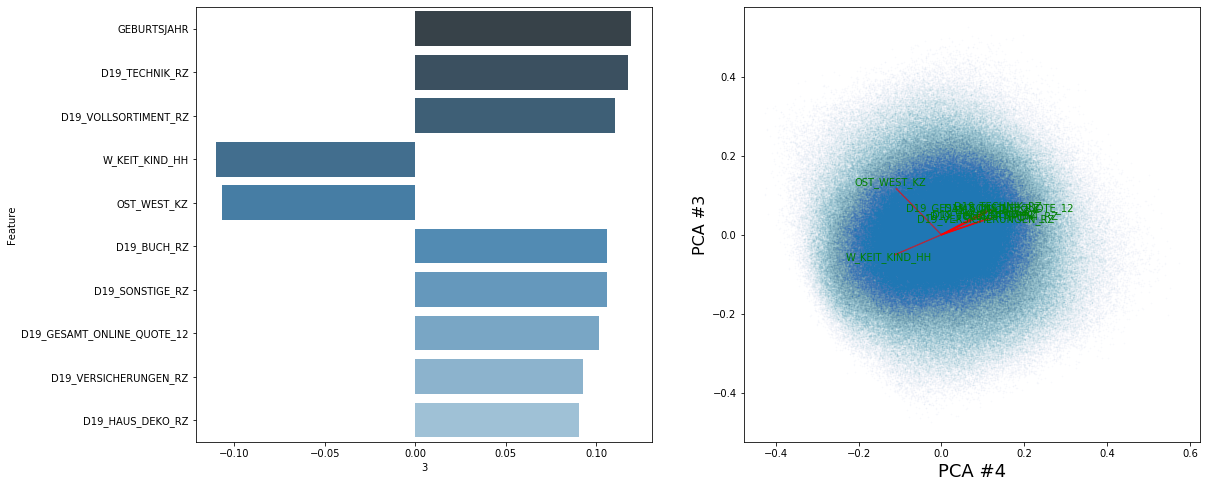

In [92]:
feature_importance_df = pca_explainer(pca = joint_dataset_PCA_reduced, 
                    pca_comonents = pca.components_, 
                    pca_num=4, 
                    n_weights=10,
                                      # Plotting/Figure parameters
                    alpha=0.025,
                    size=.5,
                    plot_arrows=True,
                    width=18,height=8)

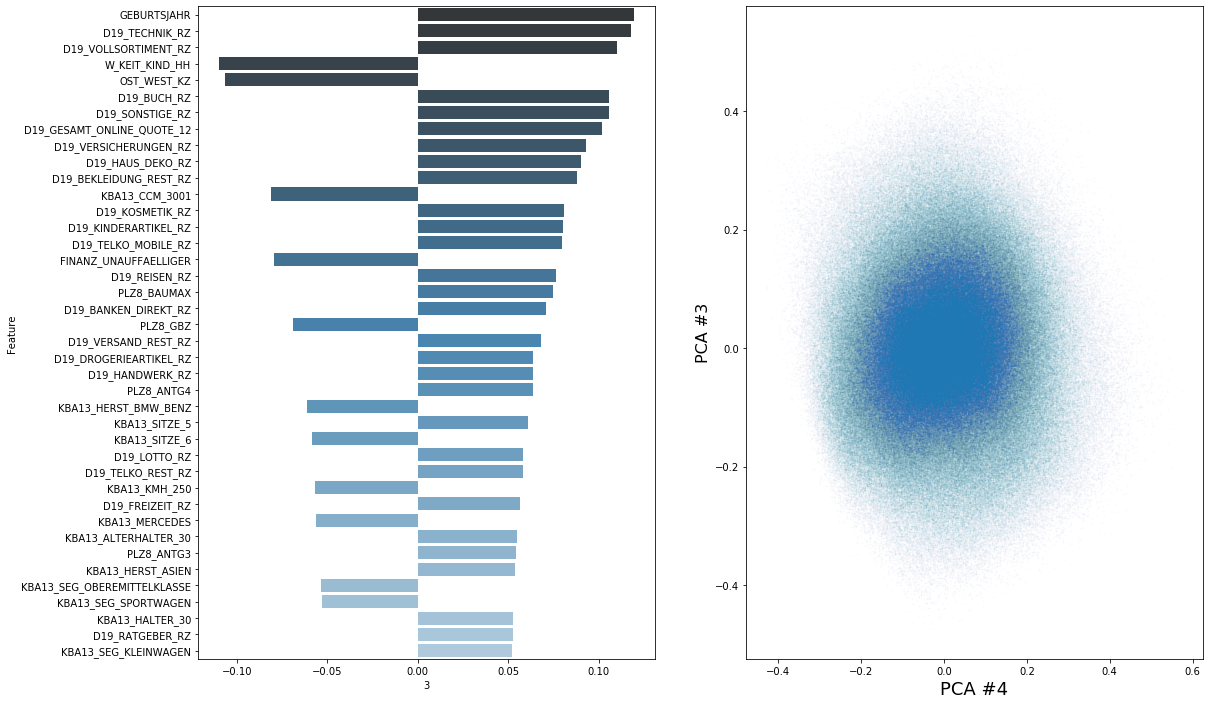

In [94]:
feature_importance_df = pca_explainer(pca = joint_dataset_PCA_reduced, 
                    pca_comonents = pca.components_, 
                    pca_num=4, 
                    n_weights=40,
                                      # Plotting/Figure parameters
                    alpha=0.025,
                    size=.5,
                    plot_arrows=False,
                    width=18,height=12)

### PC #4 description


 

**positive feature correlation** with PCA #4:
 1. `GEBURTSJAHR`
 2. `D19_TECHNIK_RZ`
 3. `D19_VOLLSORTIMENT_RZ`
 
 4. `D19_BUCH_RZ`
 5. `D19_SONSTIGE_RZ`
 6. `D19_GESAMT_ONLINE_QUOTE_12`
 
 7. `D19_VERSICHERUNGEN_RZ`
 8. `D19_HAUS_DEKO_RZ`
 

**negative feature correlation** with PCA #4:
1. `W_KEIT_KIND_HH`

2. `OST_WEST_KZ`
 
Now we need to go back to the **metadata file to** read the desciption of each PC. 

**Positive values of features** MEAN for PCA#4: relatively (compared to others) high values of year of birth, hence a younger sub-population, with low MAIL-ORDER transactional activity in the past 24 months in the domains: technology, "COMPLETE MAIL-ORDER OFFERS", books and cds, insurances, clothing, cosmetics, children articles, house decor, and other categories, but overall almost all transations taken ONLINE (as opposed to by traditional MAIL).  

**Negative values of features** for PCA#4: is associated  with cars having less than 3000cmm capacity (lower end, cheaper), a household where children are likely present, and most likely EAST germany. 


 
In other words, interpreting the above:
- **HIGH VALUES of this PC axes** mean young people, with activity predominantly over the web, rather than through mail-order. This group is likely to have children. This group is less likely to have expensive cars, likely smaller `KLEINWAGEN`, and is also most  associated with eastern parts of Germany, where, due to historical reasons, the accumulated wealth is smaller, than western parn. This group is more likely to live in a zip code are (PLZ8) that comrpises 6-10, and >10 family houses. 

- **LOW VALUES of this PC axes**  means older people, more likely to use mail-order placement than online purchases. Also they would likely be more likely to have more expensive cars, and be more prevalent in western germany.  They are much less likely to have children (small children) in the house.
    

# PCA #5

## MAIL-ORDER likelihood (associated with social orientation) vs critical, fightful, dominant ONLINE shoppers

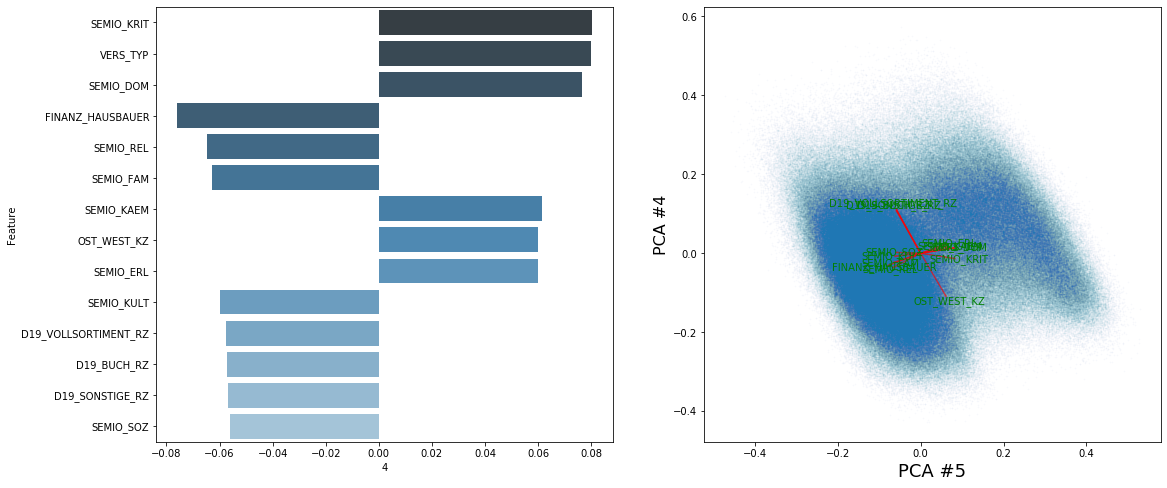

In [100]:
feature_importance_df = pca_explainer(pca = joint_dataset_PCA_reduced, 
                    pca_comonents = pca.components_, 
                    pca_num=5, 
                    n_weights=14,
                                      # Plotting/Figure parameters
                    alpha=0.025,
                    size=.5,
                    plot_arrows=True,
                    width=18,height=8)

### PC #5 description

 

**positive feature correlation** with PCA #5:
1. `SEMIO_KRIT`
2. `VERS_TYP`
3. `SEMIO_DOM`

4. `SEMIO_KAEM`
5. `OST_WEST_KZ`
6. `SEMIO_ERL`

**negative feature correlation** with PCA #5:
1. `FINANZ_HAUSBAUER`
2. `SEMIO_REL`
3. `SEMIO_FAM`
4. `SEMIO_KULT`
 
Now we need to go back to the **metadata file to** read the desciption of each PC. 

**Positive values of features** MEAN for PCA#5: A segment of population to be very low in critical, dominant, fightfull attitude, but rather acting as an individual accepting risks, however also socially driven one. Has low "eventful orientation" (`SEMIO_ERL` - whatever that feature means) and is most likely from WEST germany. 



**Negative values of features** for PCA#5: Very high affinity towards culture, "familiar-mindedness", religion, whose major focus is to OWN a house. A multibuyer of COMPLETE MAIL-ORDER OFFERS.

 
In other words, interpreting the above:
- **HIGH VALUES of this PC axes**  A segment of population oriented towards culture, familiarity, religion, owning a house, whose major attitudes don't include aggressive/fightful attitude, low critical thinking. However they are willing to accept risks, but they are also socially (community) minded. They are a multibuyers of COMPLETE MAIL-ORDER OFFERS.

- **LOW VALUES of this PC axes** : A segment of population that includes more self-oriented individuals, less likely to COMPLETE MAIL-ORDER OFFERS, less religious, community-driven, with high criticial, dominant and fightfull atitudes. Less likely from WEST germany.

---
# Interpreting market segments

Having interpreted the **PCA axes**, and its highly positive and negative values, and also the **composition of each cluster**. It is possible to **write up** the customer segment interpretations.

1. `Cluster_0`:

Consists of a population that:
Is rather poor, strongly saving money,
without lots of cars (or any expensive ones), and lives in less densely populated areas - to medium populated areas
Traditional and most likely religious
Most likely living in east Germany
Do not consider themselves “green”

    
2. `Cluster_1`
Rather wealthy individuals
Not oriented on saving, but on “financial preparedness” (wise spending?)
Can Have multiple cars
Live in wealthy neighborhoods
Might have children
Less traditionally religious, 
more swayed by emotions
Slightly older people (not like young (and poor) parents, but rather wealthy mid 30s parents)


3. `Cluster_2`
Not rich individuals (less likely to have MULTIPLE luxury cars)
Strong savers with money management skills
Rational
Most likely traditionally religious
Less populated areas 
Might come from west Germany
With an affinity towards luxury cars (but do not have them a lot, but an affinity towards luxury)
     

4. `Cluster_3`
Rather not wealthy
With children
Not focused on money savings
Considerate about financial preparedness

    - is described primarily by **negative PC2 and PC1** with strongly negative PC2 values

5. `Cluster_4`
Comparable to cluster 3, but the proportions are shifted:
Poor
With children
Wise spender, slight money saver
Swayed by emotions
 
6. `Cluster_5`
Most likely without children
Strong orientation on money saving
Focus on money management
Rational
Traditionally religious


 
7. `Cluster_6`
Very wealthy ( the most wealthy customer segment)
older people, 
Less likely to use mail-order placement than online purchases.
    
8. `Cluster_7`
Oriented toward family and likely to have children
On the younger side of life
Moderately wealthy
Has moderate to small cars
Slight association with east germany
More likely to use mail-order offers, but also buying online
Rather High density areas
Oriented somewhat towards money saving
rational  & traditionally religious
    


# Identifying important market parts

First to recapitulate the customer segments as compared to general population

Clusters 1, 3, 6, 7:: - these are the segments of general population for which Arvato has relatively less customers. Meaning this segment of population is less likely to use the services, as customers from this segment are less prevalent in our customer dataset.

Clusters 0, 2 : - these are the segments of general population that are overrepresented in Arvato customer base. Meaning, this segment of population is much more likely (constitutes higher percentage) to use Arvato services.

Cluster 4,5: - this is the segment of population that is equally represented in customers dataset with relatively high percentage. Meaning this is also an important from the business perspective segment of the market.


## Highly important customer segments

We see that the cluster 0 and 2 are more abundant in Arvato customer base than in general population. In fact they constitue around 60% of Arvato customers. 

**Cluster 2** is the most present (40.5%) in Arvato's customer data. These individuals belong to a group that is not comprising with very right individuals, that tend toward money saving and management, but come from west germany and have an affinity toward luxury goods

**Cluster 0** is comprising of rather wealthy individuals, slightly older people, more swayed by emotions.



## Important segments

Cluster **4** is more likely to use mail-order, strong orientation on  money saving,  wise spender, but swayed by emotions.
Cluster **5** are also money savers, traditionally religious

## Less important segments

Are populations generally very wealthy or morderately wealthy, and/or not concerned with money saving

---
# Comments

The above interpretation is only very brief. In particular a lot of time and effort could be spend to understand the quantitative differences between these groups, preparing very detailed plots and variance analysis. 

But since the scope of the project is **also to predict** whether a given customer is more or less likely to use provided services, I am going to propose a supervised solution, discussed in a separate notebook in folder `supervised`.